In [31]:
import numpy as np

## NL Dataset

In [32]:
!git clone https://github.com/HansBambel/multidim_conv.git

fatal: destination path 'multidim_conv' already exists and is not an empty directory.


In [33]:
!ls ./multidim_conv/data/Wind_data_NL/

dataset.pkl  scaler.pkl


In [34]:
import pickle
with open('./multidim_conv/data/Wind_data_NL/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('./multidim_conv/data/Wind_data_NL/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [35]:
scaler

{'Features': ['Wind speed in 0.1m/s',
  'Wind direction in degrees (360 North, 90 East, 0 No wind)',
  'Temperature in 0.1C',
  'Dew Point in 0.1C',
  'Air Pressure in 0.1hpa',
  'Rain amount in 0.1mm'],
 'feature_min_train': array([ 0.000e+00,  0.000e+00, -1.950e+02, -2.170e+02,  9.681e+03,
        -1.000e+00]),
 'feature_max_train': array([  240.,   360.,   376.,   230., 10462.,   481.])}

- size of train data: 70128
- size of test data: 10872
- number of features: 6 (wind speed, wind direction, temperature, rain amount, air pressure, dew point)
- number of cities in the study: 7 

In [36]:
train_data = data['train']
test_data = data['test']
train_data.shape, test_data.shape

((70128, 7, 6), (10872, 7, 6))

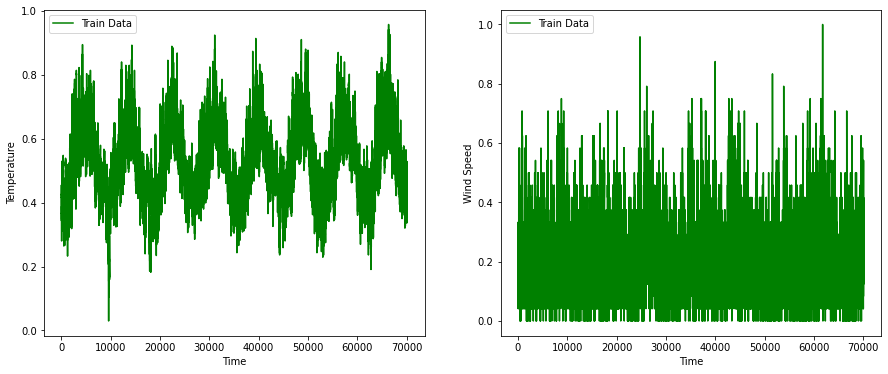

In [37]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(range(len(train_data[:, 0, 2])), train_data[:, 0, 2], 'g', label="Train Data")
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature')
ax1.legend(loc="upper left")
ax2.plot(range(len(train_data[:, 0, 0])), train_data[:, 0, 0], 'g', label="Train Data")
ax2.set_xlabel('Time')
ax2.set_ylabel('Wind Speed')
ax2.legend(loc="upper left")
plt.show()

In [73]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def build_data(data, x_len, y_len, gap=1):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len-gap:end_idx-gap]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y


"""Build data and train test split"""
def make_ready_data(data, train=True, gap=1):
    x_len = 10  # 10 historical time steps
    y_len = 1  # next step
    
    x, y = build_data(data[:, :, 0], x_len, y_len, gap)
    x, y = x.reshape(x.shape[0], 7*10), y.reshape(y.shape[0], 7*1)
    
    if train:
        xtrain = x[:60000]
        ytrain = y[:60000]
        xval = x[60000:]
        yval = y[60000:]
    
        return xtrain, xval, ytrain, yval
    else:
        return x, y

xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=1)
xtest, ytest = make_ready_data(test_data, train=False, gap=1)
xtrain.shape, xval.shape, ytrain.shape, yval.shape,xtest.shape, ytest.shape

((60000, 70), (10116, 70), (60000, 7), (10116, 7), (10860, 70), (10860, 7))

In [74]:
"""MLP basic model"""
import torch
from torch import nn

class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(in_features=70, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=7),
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

In [75]:
def build_dl(xtrain, xval, xtest, ytrain, yval, ytest):
    """convert arrays to tensors"""

    xtrain = torch.Tensor(xtrain).to(device)
    ytrain = torch.Tensor(ytrain).to(device)
    xval = torch.Tensor(xval).to(device)
    yval = torch.Tensor(yval).to(device)
    xtest = torch.Tensor(xtest).to(device)
    ytest = torch.Tensor(ytest).to(device)

    batch_size = 32
    train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    val_data = torch.utils.data.TensorDataset(xval, yval)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    test_data = torch.utils.data.TensorDataset(xtest, ytest)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    
    return train_iter, val_iter, test_iter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

## 1 time step Gap

Here we predict the time step after the next time step

In [76]:
"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_iter:
            outputs = model(x)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss


"""Train loop"""
def run_train(model):
    NUM_EPOCHS = 50
    for epoch in range(NUM_EPOCHS):
        losses = []
    
        for x, y in train_iter:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        train_loss = np.mean(losses)
        val_loss = validate(model) 
    
        if epoch % 5 == 0:
            print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)
                  
    return model
                  
loss_fn = nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mlp().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
model = run_train(model)

Epoch:  1 , Train Loss:  0.002857303937152028 , Val Loss:  0.003087685
Epoch:  6 , Train Loss:  0.0017910094457368056 , Val Loss:  0.0019399986
Epoch:  11 , Train Loss:  0.0017315855632846554 , Val Loss:  0.0018336702
Epoch:  16 , Train Loss:  0.0016827432887007792 , Val Loss:  0.0018339101
Epoch:  21 , Train Loss:  0.0016569269081577658 , Val Loss:  0.0018227681
Epoch:  26 , Train Loss:  0.0016345325379321972 , Val Loss:  0.0017898948
Epoch:  31 , Train Loss:  0.0016078876896450916 , Val Loss:  0.0017606695
Epoch:  36 , Train Loss:  0.0015908772454597056 , Val Loss:  0.0017828407
Epoch:  41 , Train Loss:  0.0015696571254792313 , Val Loss:  0.0016670065
Epoch:  46 , Train Loss:  0.0015601920067332684 , Val Loss:  0.0017462326


In [77]:
"""Test data predictions"""
def run_test(model):
    model.eval()
    y_preds = list()
    y_true = list()

    max_wind = scaler['feature_max_train'][0]
    min_wind = scaler['feature_min_train'][0]

    with torch.no_grad():
        for x, y in test_iter:
            y = y.cpu().numpy().reshape(-1)
            y_pred = model(x).view(len(y), -1).cpu().numpy().reshape(-1)
            y = y * max_wind + min_wind
            y_pred = y_pred * max_wind + min_wind
            y_preds.extend(list(y_pred))
            y_true.extend(list(y))
        
    y_preds = np.array(y_preds)
    y_true = np.array(y_true)
    y_true = y_true.reshape(int(y_true.shape[0]/7), 7)
    y_preds = y_preds.reshape(int(y_preds.shape[0]/7), 7)
    
    return y_true, y_preds

y_true, y_preds = run_test(model)

RMSE:  10.014055
MAE:  7.569874


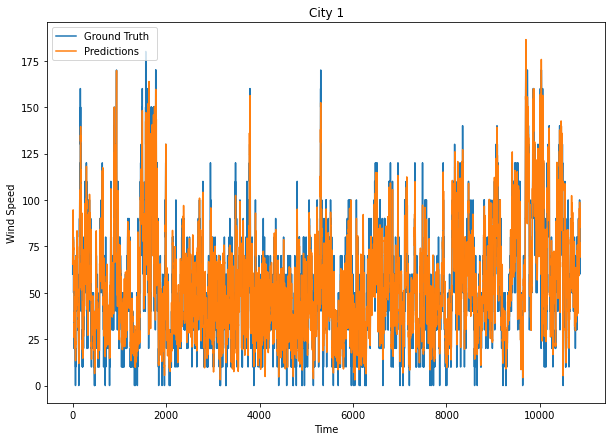

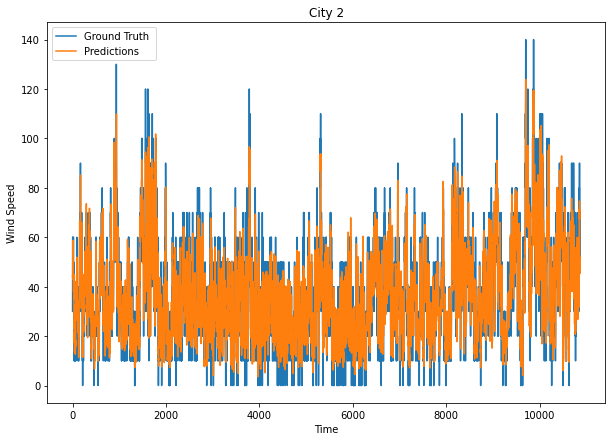

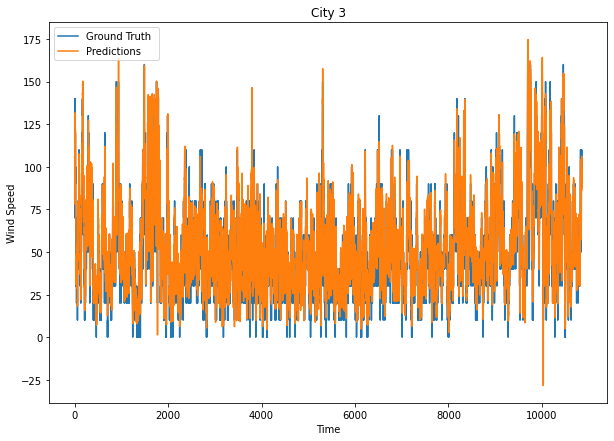

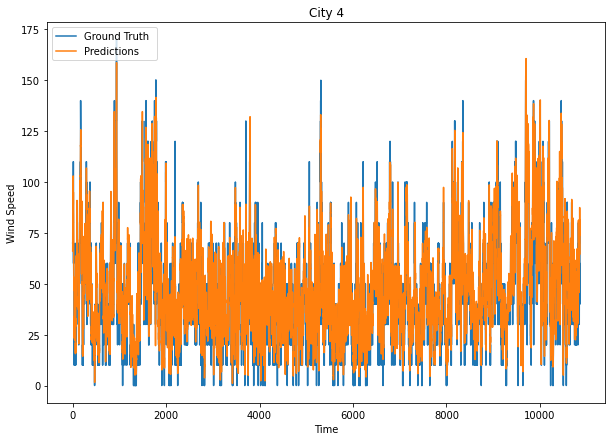

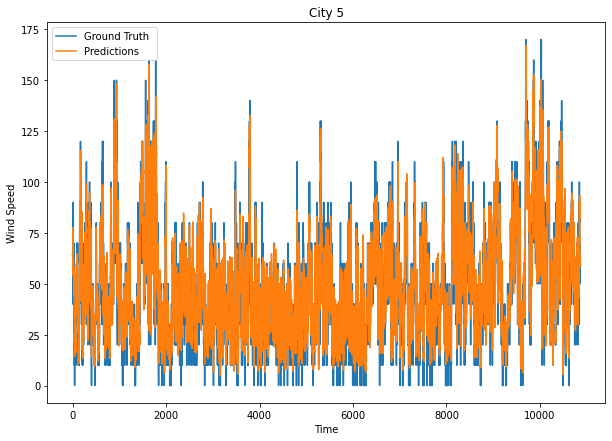

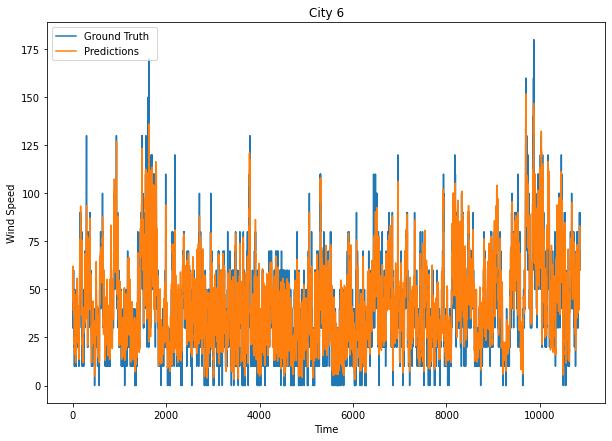

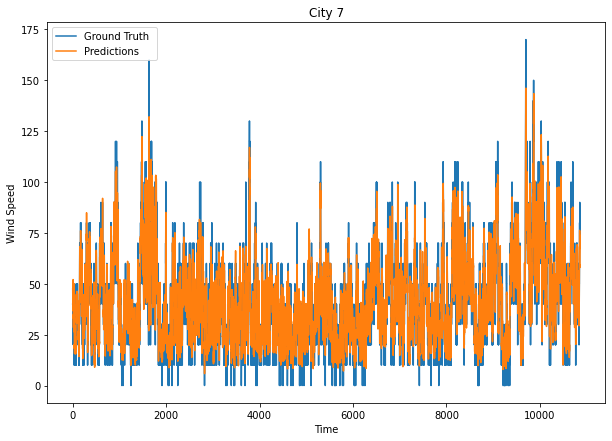

In [78]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def results(y_true, y_preds, plots=True):
    """Visualization of windspeed predictions vs ground truth and
    Overall evaluation the predictions of the test data"""
    
    print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
    print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

    if plots:
        for i in range(7):
            plt.figure(figsize=(10,7))
            plt.plot(range(len(y_true[:, i])), y_true[:, i], label='Ground Truth ')
            plt.plot(range(len(y_preds[:, i])), y_preds[:, i], label='Predictions')
            plt.title('City '+str(i+1))
            plt.xlabel('Time')
            plt.ylabel('Wind Speed')
            plt.legend(loc="upper left")
            plt.show()
        
results(y_true, y_preds, plots=True)

RMSE:  9.433639
MAE:  7.2868333


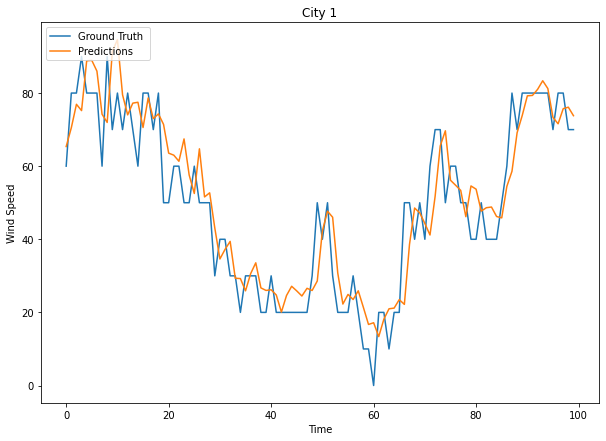

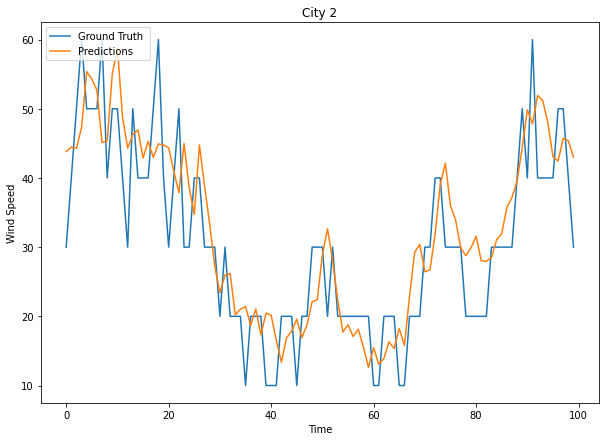

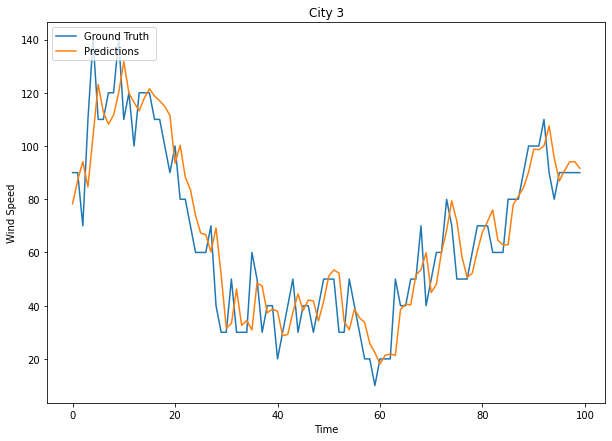

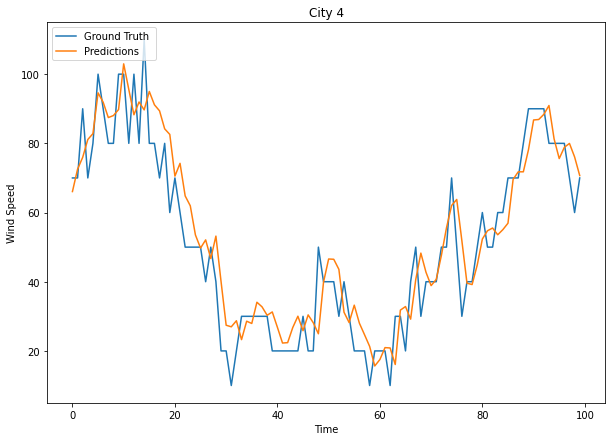

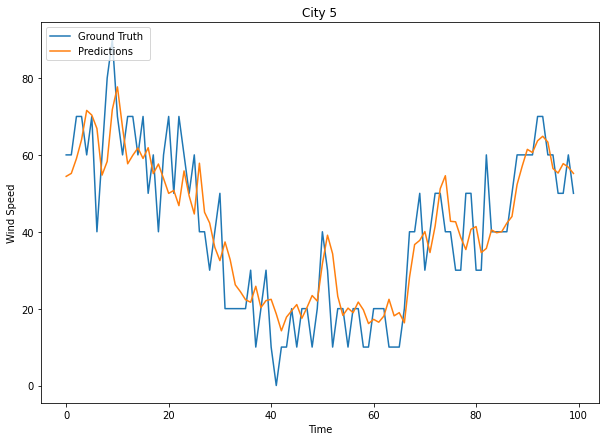

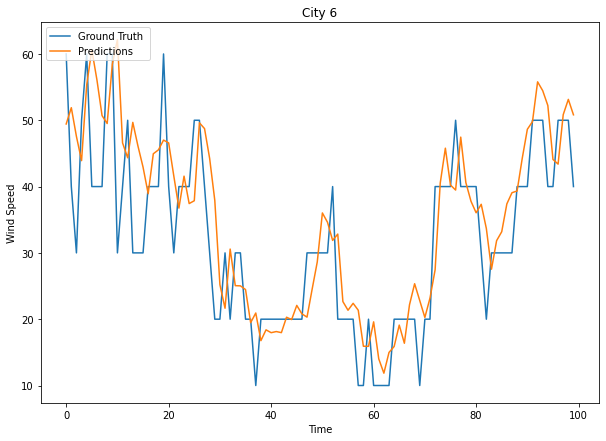

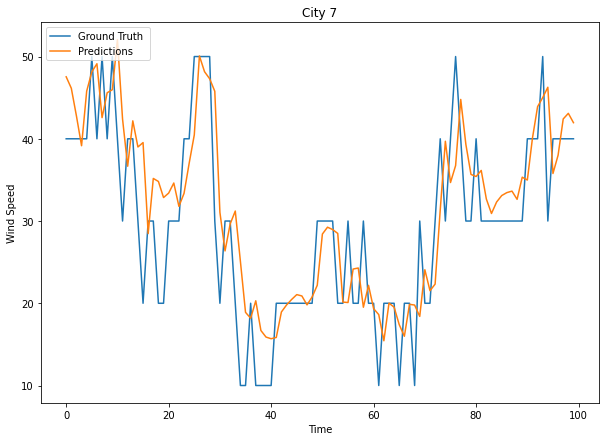

In [79]:
results(y_true[:100], y_preds[:100], plots=True)

## 5 time steps Gap

Here the gap between the train X and y is 5 time steps

In [80]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=5)
xtest, ytest = make_ready_data(test_data, train=False, gap=5)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)
model = mlp().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
model = run_train(model)

Epoch:  1 , Train Loss:  0.0028067758140464623 , Val Loss:  0.002977048
Epoch:  6 , Train Loss:  0.0017802730039072534 , Val Loss:  0.0021576225
Epoch:  11 , Train Loss:  0.001700142913684249 , Val Loss:  0.0018111388
Epoch:  16 , Train Loss:  0.0016677585784966747 , Val Loss:  0.0017927401
Epoch:  21 , Train Loss:  0.0016543680054446062 , Val Loss:  0.0018118453
Epoch:  26 , Train Loss:  0.0016434759767415623 , Val Loss:  0.0018010781
Epoch:  31 , Train Loss:  0.0016279416952282191 , Val Loss:  0.0017702746
Epoch:  36 , Train Loss:  0.0016058351909120877 , Val Loss:  0.0017408095
Epoch:  41 , Train Loss:  0.0015942744911027452 , Val Loss:  0.0017510799
Epoch:  46 , Train Loss:  0.0015875066585838795 , Val Loss:  0.001739984


In [81]:
y_true, y_preds = run_test(model)
results(y_true, y_preds, plots=False)

RMSE:  10.195417
MAE:  7.7289214


# 10 time steps Gap

In [82]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=10)
xtest, ytest = make_ready_data(test_data, train=False, gap=10)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)
model = mlp().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
model = run_train(model)

Epoch:  1 , Train Loss:  0.0027793069735479853 , Val Loss:  0.002896942
Epoch:  6 , Train Loss:  0.00178142249872908 , Val Loss:  0.0020101543
Epoch:  11 , Train Loss:  0.0017241699785304565 , Val Loss:  0.0018371313
Epoch:  16 , Train Loss:  0.0016785202344569068 , Val Loss:  0.0017967221
Epoch:  21 , Train Loss:  0.0016571059382831056 , Val Loss:  0.0017899482
Epoch:  26 , Train Loss:  0.0016438226210263869 , Val Loss:  0.0017688025
Epoch:  31 , Train Loss:  0.0016351431430007021 , Val Loss:  0.0018571618
Epoch:  36 , Train Loss:  0.0016213172916943828 , Val Loss:  0.0018159489
Epoch:  41 , Train Loss:  0.0016043454286952814 , Val Loss:  0.0017678513
Epoch:  46 , Train Loss:  0.0015917003214669723 , Val Loss:  0.0017711255


In [83]:
y_true, y_preds = run_test(model)
results(y_true, y_preds, plots=False)

RMSE:  10.201199
MAE:  7.7350583


## 50 time steps Gap

In [84]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=50)
xtest, ytest = make_ready_data(test_data, train=False, gap=50)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)
model = mlp().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
model = run_train(model)

Epoch:  1 , Train Loss:  0.0027589505901249745 , Val Loss:  0.0029446452
Epoch:  6 , Train Loss:  0.0017461277338055273 , Val Loss:  0.0020375622
Epoch:  11 , Train Loss:  0.001661018893433114 , Val Loss:  0.0017156495
Epoch:  16 , Train Loss:  0.0016317589613298576 , Val Loss:  0.0017410195
Epoch:  21 , Train Loss:  0.0016134762013331055 , Val Loss:  0.0017418102
Epoch:  26 , Train Loss:  0.0016032075531159837 , Val Loss:  0.0017512573
Epoch:  31 , Train Loss:  0.0015938835870474577 , Val Loss:  0.0017618433
Epoch:  36 , Train Loss:  0.0015855186150098841 , Val Loss:  0.001743519
Epoch:  41 , Train Loss:  0.0015791285415490469 , Val Loss:  0.0017155091
Epoch:  46 , Train Loss:  0.0015641897884818416 , Val Loss:  0.0017104794


In [87]:
y_true, y_preds = run_test(model)
results(y_true, y_preds, plots=False)

RMSE:  9.969079
MAE:  7.535005


# References:

- Trebing, Kevin and Mehrkanoon, Siamak, 2020, Wind speed prediction using multidimensional convolutional neural networks